## Correlation between news and stock movement

Import the necessary libraries

In [87]:
import pandas as pd
import yfinance as yf
import nltk
from textblob import TextBlob
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

Load and Prepare the Data

In [88]:
# Load your dataset into a pandas DataFrame
file_path = '../data/raw_analyst_ratings.csv'
df = pd.read_csv(file_path)

In [8]:
# Convert the 'date' column to datetime format and UTC-4 timezone
df['date'] = pd.to_datetime(df['date'], format='ISO8601', utc=True)

In [ ]:
# Fetch stock prices using yfinance
def fetch_stock_data(symbol, start_date, end_date):
    ticker = yf.Ticker(str(symbol))
    return ticker.history(start=start_date, end=end_date)

# Identify unique stock symbols and their frequencies
symbols = df['stock'].value_counts().index[:5]  # Get the top 5 most frequent symbols

# Calculate date ranges for each of the stocks
date_ranges = {}
for symbol in symbols:
    symbol_data = df[df['stock'] == symbol]
    start_date = symbol_data['date'].min()
    end_date = symbol_data['date'].max()
    date_ranges[symbol] = (start_date, end_date)

# Fetch stock prices and align with dates
stock_data = {}
for symbol, (start_date, end_date) in date_ranges.items():
    if pd.notnull(symbol):  # Check if symbol is not NaN
        stock_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

In [ ]:
# Sentiment Analysis using TextBlob
def get_sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [ ]:
# Calculate Daily Stock Returns and Sentiment Scores for each stock
correlation_coefficients = {}
for symbol in symbols:
    news_data = df[df['stock'] == symbol]
    news_data.rename(columns={"date": "Date"}, inplace=True)
    stock_df = pd.DataFrame(stock_data[symbol])
    merged_data = pd.merge(stock_df, news_data, on='Date')

    # Apply Sentiment Analysis to headlines
    merged_data['Sentiment_Score'] = merged_data['headline'].apply(get_sentiment_score)

    # Calculate Daily Stock Returns
    merged_data['Daily_Return'] = merged_data['Close'].pct_change()

    # Calculate daily average sentiment scores by aggregating sentiment scores for each day
    daily_sentiment = merged_data.groupby(merged_data['Date'].dt.date)['Sentiment_Score'].mean().reset_index()

    # Convert 'Date' column to datetime in both dataframes
    merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='ISO8601', utc=True).dt.normalize()
    daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], format='ISO8601', utc=True).dt.normalize()

    # Rename 'Sentiment_Score' column in 'daily_sentiment' before merging
    daily_sentiment.rename(columns={"Sentiment_Score": "Daily_Avg_Sentiment_Score"}, inplace=True)

    # Merge daily stock returns with daily average sentiment scores
    merged_data = pd.merge(merged_data, daily_sentiment, on='Date')

    # Compute the correlation coefficient
    correlation_coefficient = merged_data['Daily_Return'].corr(merged_data['Sentiment_Score'])
    correlation_coefficients[symbol] = correlation_coefficient

/tmp/ipykernel_5780/3511651981.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data.rename(columns={"date": "Date"}, inplace=True)
/tmp/ipykernel_5780/3511651981.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data.rename(columns={"date": "Date"}, inplace=True)
/tmp/ipykernel_5780/3511651981.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data.rename(columns={"date": "Date"}, inplace=True)
/tmp/ipykernel_5

Correlation Coefficient between Daily Stock Returns and Sentiment Scores for MRK: 0.03265919257076078
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for MS: 0.047562784784221726
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for NVDA: 0.0028304101084350025
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for MU: 0.05170503842746065
Correlation Coefficient between Daily Stock Returns and Sentiment Scores for QQQ: 0.07611565834181155


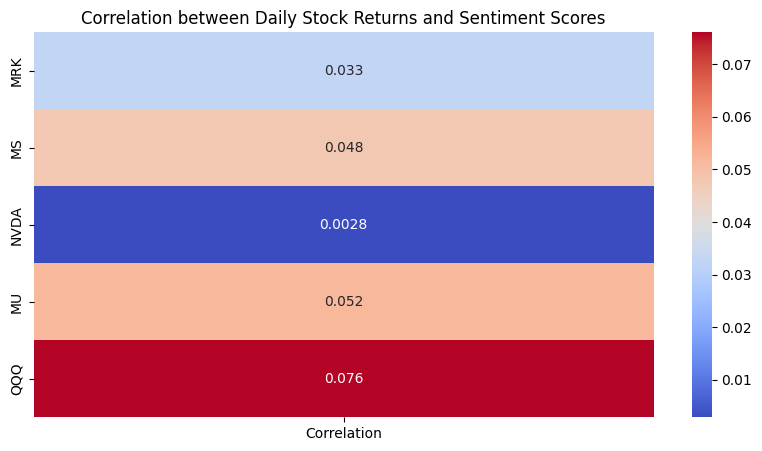

In [86]:
# Print Correlation Coefficients
for symbol, correlation in correlation_coefficients.items():
    print(f"Correlation Coefficient between Daily Stock Returns and Sentiment Scores for {symbol}: {correlation}")

# Visualization
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(correlation_coefficients, index=['Correlation']).T, annot=True, cmap='coolwarm')
plt.title('Correlation between Daily Stock Returns and Sentiment Scores')
plt.show()